In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

import copy
import pdb

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Testing my trained model

Now for the fun stuff! 

## 1. Learning Curves

In [2]:
with open("history/history-merge-date_5-18-14-40.pkl", "rb") as handle:
    history = pickle.load(handle)

In [3]:
def plot_loss(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

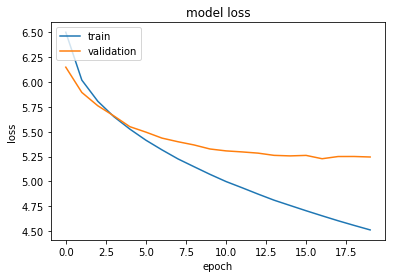

In [105]:
plot_loss(history)

It looks like at around epoch 15-17 the validation loss plateaus. 

In [3]:
with open("history/history-inject-date_5-16-15-45.pkl", "rb") as handle:
    history2 = pickle.load(handle)

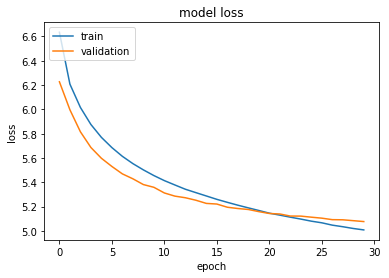

In [5]:
plot_loss(history2)

It looks like the second model is less prone to ovrfitting, but achives around the same validation loss. In general, this seems like a more healthy learning curve.

## 2. A function for generating predictions

In [2]:
with open("../data/tokenizer/tokenizer.pkl","rb") as handle:
    tokenizer = pickle.load(handle)
handle.close()

In [4]:
# see if loaded properly - should be 30212
1 + len(tokenizer.word_index)

30212

Now we have a dictionary of the form {word:index}. We can quickly create a dictionary of the form {index:word} to decode the predicted sequences. 

In [3]:
reverse_tokenizer = {index: word for word,index in tokenizer.word_index.items()} 

### TEMP - later change the definition of `get_photo_features` to do the whole process of preprocessing an image, and puting it through the VGG network.

In [5]:
with open("../data/features/valid_features.pkl", "rb") as handle:
    valid_features = pickle.load(handle)
handle.close()

In [6]:
valid_ids = []
for k in valid_features:
    valid_ids.append(k)

In [13]:
def get_photo_features(photo_id):
    return valid_features[photo_id]

In [106]:
# Get the language model
model1 = load_model("models/model_merge-date_5-18-14-40-ep016-loss4.704_lr-0.010000_patience-3.h5")

In [107]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs-photo (InputLayer)       (None, 4096)         0                                            
__________________________________________________________________________________________________
Inputs-caption (InputLayer)     (None, 15)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4096)         16781312    Inputs-photo[0][0]               
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 300)      9063600     Inputs-caption[0][0]             
__________________________________________________________________________________________________
dropout_1 

In [7]:
model2 = load_model("models/model_inject-date_5-16-15-45-ep030-loss5.009_lr-0.010000_patience-3.h5")

In [11]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs-photo (InputLayer)       (None, 4096)         0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           Inputs-photo[0][0]               
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          1229100     dropout_1[0][0]                  
__________________________________________________________________________________________________
Inputs-caption (InputLayer)     (None, 15)           0                                            
__________________________________________________________________________________________________
repeat_vec

In [8]:
def generate_predictions_id(photo_id, model, tokenizer, reverse_tokenizer, max_length = 15):
    photo_features = get_photo_features(photo_id)
    # build up an array for the output sequence
    in_seq = np.repeat(0, max_length)
    in_seq[0] = tokenizer.word_index["startseq"]
    # keep track of the end token
    end_token = tokenizer.word_index["endseq"]
    for i in range(1, max_length):
        # get the prediction of the next word 
        pred = model.predict([photo_features,in_seq.reshape(1,-1)], verbose=0)
        # get just the index that is predicted
        pred = np.argmax(pred)
        in_seq[i] = pred
        # check if you've preached the end token
        if pred == end_token:
            break
    """
    Now, convert the list of integers corresponding to words to acutal words
    """
    # remove the `startseq` token at the front.
    out_seq = in_seq[1:]
    # build up the ouptut string
    out_string = []
    for idx in out_seq:
        if idx == 0 or idx == end_token:
            break
        out_string.append(reverse_tokenizer[idx])
    return(" ".join(out_string))

In [58]:
[.9**i for i in range(15)]

[1.0,
 0.9,
 0.81,
 0.7290000000000001,
 0.6561,
 0.5904900000000001,
 0.531441,
 0.4782969000000001,
 0.4304672100000001,
 0.3874204890000001,
 0.3486784401000001,
 0.31381059609000006,
 0.2824295364810001,
 0.2541865828329001,
 0.2287679245496101]

In [115]:
class SequenceCandidate(object):
    
    @staticmethod
    def template_seq(start_idx = 1, max_length = 15, ignore_idx = None, alpha = .9):
        seq = np.repeat(0,15)
        seq[0] = start_idx
        # also keep track of the probabilities you've seen
        probs = np.repeat(0.0,15)
        probs[0] = 1
        return SequenceCandidate(seq, probs, max_length, ignore_idx, alpha)
        
        
    
    def __init__(self, seq, probs, max_length = 15, ignore_idx = None, alpha = .9):
        assert len(seq) == max_length
        self._max_length = max_length
        self._seq = seq
        self._probs = probs
        # store the number of populated elements in sequence
        self._num_elem = max_length # temporarily assume sequence is fully populated. 
        for i in range(len(seq)):
            if seq[i] == 0:
                self._num_elem = i # update number of elements in the sequence. 
                break
        # keep track of which bigrams are in the sequence
        self._bigrams = set()
        self._ignore_idx = ignore_idx
        if ignore_idx is None:
            self._ignore_idx = []
        self._prob_weights = [alpha**i for i in range(max_length)]
    
    # returns a new candidate, with the new token added
    def add_token(self, token, prob):
        # see that there's room to add in the sequence
        if self._num_elem >= self._max_length:
            raise IndexError("Sequence is already populated.\nCan't add any more tokens to it.")
        # get a copy of the new candidate
        newcandidate = copy.deepcopy(self)
        # add the token to the sequence
        newcandidate._seq[self._num_elem] = token
        # update the probability sum
        newcandidate._probs[self._num_elem] = prob
        # add the newly added bigram to the list of bigrams
        newcandidate._bigrams.add(tuple(newcandidate._seq[self._num_elem - 1 : newcandidate._num_elem + 1]))
        # increment the number of stored elements
        newcandidate._num_elem += 1
        return(newcandidate)
    
    def probsum(self):
        # sum of the word probabilities, ignoring the indecies in `ignore_idx`.
        valid_probs = self._probs[~np.in1d(self._seq, self._ignore_idx)]
        # return a weighted sum
        return np.sum(np.multiply(valid_probs, self._prob_weights[:len(valid_probs)]))
    
    def final_token(self):
        return self._seq[self._num_elem - 1]
    
    # it is assumed that the first word is the start token <startseq>, so it is ignored. 
    def to_words(self,reverse_tokenizer, end_idx):
        # build up the words you want to output
        out_words = []
        for i in range(1,len(self._seq)):
            # current word index
            idx = self._seq[i]
            if idx == 0 or idx == end_idx:
                break
            if idx in self._ignore_idx:
                continue
            # don't add repeated words
            if self._seq[i - 1] != idx:
                out_words.append(reverse_tokenizer[idx])
        out_string = " ".join(out_words)
        return out_string
    
    # make the object sortabe **by the sum of the probability**
    def __lt__(self, other):
        try:
            return self.probsum() < other.probsum()
        except AttributeError: # don't know how to compare with general objects
            return NotImplemented

In [116]:
def generate_predictions_beam_id(photo_id, model,reverse_tokenizer, width, num_neighbors,
                                 top_n = 3, end_idx = 2, max_length = 15, ignore_idx = [4], alpha = .9):
    # isolate the photo features
    photo_features = get_photo_features(photo_id)
    # keep track of the accepted sequences
    accepted_sequences = []
    # keep track of the current population
    population = []
    # add a start sequence to the population
    start_sequence = SequenceCandidate.template_seq(ignore_idx = ignore_idx, alpha = alpha)
    population.append(start_sequence)
    for i in range(max_length - 1):
        tmp = []
        for cand_seq in population:
            # get the prediction of the next word 
            pred = model.predict([photo_features, cand_seq._seq.reshape(1,-1)], verbose=0)[0]
            # sort the predicted next words by their probabilities
            pred_argsort = pred.argsort()
            # add candidates for each of the <num_neighbors> neighbors
            for next_idx in pred_argsort[-num_neighbors:]:
                # if we're starting to repeat bigrams, accept the current candidate
                if (cand_seq.final_token(), next_idx) in cand_seq._bigrams:
                    accepted_sequences.append(cand_seq)
                    continue
                # add the predicted word to get a new candidate
                next_prob = pred[next_idx]
                new_candidate = cand_seq.add_token(next_idx,next_prob)
                # if the next suggested token is <endseq>, add to accepted_sequences
                if next_idx == end_idx:
                    accepted_sequences.append(new_candidate)
                else:
                    tmp.append(new_candidate)
        # prune the population to keep only the top <width> candidates. 
        try:
            population = sorted(tmp)[-width:]
        except:
            # fewer than <width> individuals remain - stop growing tree and keep curren partial sequences
            population = tmp
            break
    # add current population to accepted sequences
    accepted_sequences = sorted(accepted_sequences + population, reverse = True)
    # build output string
    accepted = 0
    outputwords, outputprobs = [], []
    for acc_seq in accepted_sequences:
        seq_string = acc_seq.to_words(reverse_tokenizer,end_idx)
        if seq_string not in outputwords:
            outputwords.append(seq_string)
            outputprobs.append(acc_seq.probsum())
            accepted += 1
            if accepted >= top_n:
                break
    output = list(zip(outputwords, outputprobs))
    return output

In [100]:
im = Image.open("../data/yelp_photos/photos/ljYdNCFZyyXLy0xgbJSalA.jpg")

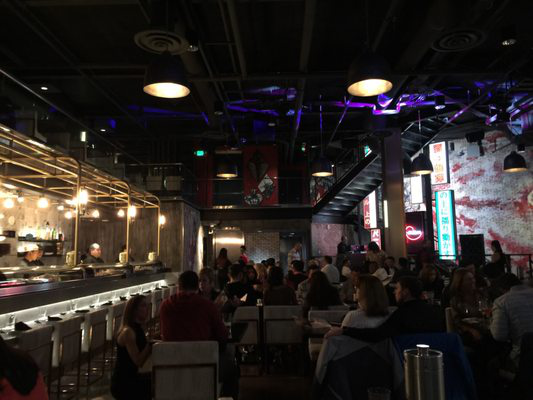

In [83]:
im

In [119]:
generate_predictions_beam_id("xd3WPCnSnaF4WvOK5X5kdQ", model2, reverse_tokenizer, width = 5,
                             num_neighbors=3, top_n = 3, ignore_idx = [4,61,345], alpha = .6)

[('beef barbacoa torta limited time only', 1.4819665131585598),
 ('beef barbacoa torta limited time only with the side of the flavor',
  1.4619489128359993),
 ('beef barbacoa torta limited time only with the side of the best',
  1.4619218618509093)]

In [111]:
list(zip([1,2],[2,4]))

[(1, 2), (2, 4)]

In [109]:
generate_predictions_beam_id("xd3WPCnSnaF4WvOK5X5kdQ", model2, reverse_tokenizer, width = 5, num_neighbors=3, alpha =1.5, top_n = 3)

[('beef barbacoa torta d limited time only', 0.222),
 ('chicken sandwich', 0.22),
 ('beef barbacoa burrito d limited time only', 0.204)]

In [94]:
def write_photos(ids, model1, alpha1, alpha2, folder = "examples/"):
    for photo_id in ids:
        im1 = Image.open("../data/yelp_photos/photos/%s.jpg"%photo_id)
        descs1 = generate_predictions_beam_id(photo_id, model1, 
                    reverse_tokenizer, width = 5, num_neighbors=3,  top_n = 3,
                                             ignore_idx = [4,61,345], alpha = alpha1)
        draw = ImageDraw.Draw(im1)
        for i in range(len(descs1)):
            draw.text((0,i*10),str(descs1[i])[1:-1],(255,0,0))
        # second photo
        im2 = Image.open("../data/yelp_photos/photos/%s.jpg"%photo_id)
        descs2 = generate_predictions_beam_id(photo_id, model1, 
                    reverse_tokenizer, width = 5, num_neighbors=3,  top_n = 3,
                                             ignore_idx = [4,61,345], alpha = alpha2)
        draw = ImageDraw.Draw(im2)
        for i in range(len(descs2)):
            draw.text((0,i*10),str(descs2[i])[1:-1],(255,0,0))
        
        # paste the two photos together
        total_width = im1.size[0] + im2.size[0]
        max_height = max(im1.size[1] , im2.size[1])
        new_im = Image.new('RGB', (total_width, max_height))
        x_offset = 0
        for im in [im1,im2]:
            new_im.paste(im, (x_offset,0))
            x_offset += im.size[0]
        
        new_im.save("%s%s.jpg"%(folder,photo_id))

In [69]:
mkdir examples


In [100]:
photo_dir = "../data/yelp_photos/photos/"

In [63]:
im = Image.open("../data/yelp_photos/photos/To6WAH5Rtok5ORBLyopnAw.jpg")



In [44]:
descs = generate_predictions_beam_id("To6WAH5Rtok5ORBLyopnAw",
                                     model1, reverse_tokenizer, width = 5, num_neighbors=3, alpha =1.5, top_n = 3)

In [64]:
draw = ImageDraw.Draw(im)
# draw.text((x, y),"Sample Text",(r,g,b))
draw.text((0, 0),str(descs[0])[1:-1],(255,0,0))
draw.text((0, 10),str(descs[1])[1:-1],(255,0,0))
draw.text((0, 20),str(descs[2])[1:-1],(255,0,0))


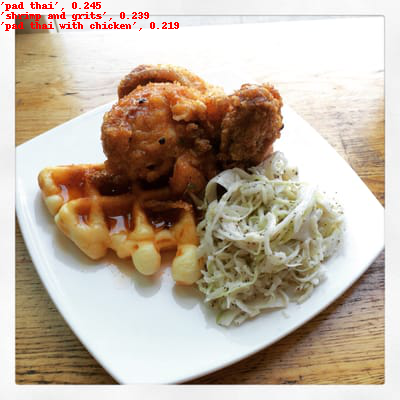

In [65]:
im

In [89]:
np.random.seed(80)
choices = np.random.choice(valid_ids, 100)
choices

array(['Fvc2DKGENEwYa5_G9ZGZFQ', 'eUg05Xta2Lt9OaZcZgz5Rw',
       'HYd6yF1rsBHbNjdXlfQ8SA', 'uHfrbb8fFXqp9eCNK2ZVHg',
       'p4bZVdiBoVfXVLPy3DQ_-w', 'DdEbSmrrxnjnm3-PL8f3PQ',
       'ljizVerWuf_VeeAN6FgbOg', '90oMDklAsojsMof8aLR2zQ',
       'rYUJ2TwvaLpTDyLU42XveQ', 'IZrBCENVnrPd6eFcjXnEmg',
       '-hx_vNxrkzkLg6sY2z_8-Q', 'h3Rka1TbCrq9oFaGAqE3Kw',
       'pny3NzlBsP-XG7Wh5zpRVA', '5THWc5YMcEWT8ZftlVYTRw',
       'FU8jygOC6N4tGFkexX5nQA', 'tfdWOKwPwDVAmJ5Geqw05w',
       'P7OWYk2qS8MamjaGw8W8hQ', '9BEMimWH5d2PpKw3Vhgxxw',
       'fPV5i-rAdREWDupQwwEkJw', 'i_Z4dH67B1Saw2lPpKL3rQ',
       '5Wsh3BMJ_0yqD_C0htlcSw', '6Mc-uMyr8-Pik21KauGnLA',
       'JnP6ise7AMgaIHv1-PxSWQ', 'OcnkbtYduo72Qcczg_7j_g',
       'ljYdNCFZyyXLy0xgbJSalA', 'q82QFxvqPecnz8FWv_TxCw',
       'K3QxDti-K7x7AK5r4pVwUQ', 'L5E4Qa0N5tPslTbxgVA7Gg',
       '6cpE9gGqFlskRRKtf_N-yg', 'rx771xlgW7kmKlgP3poOhw',
       'lLP-RgkWZUQTW3EqgN37UA', 'l-Itj_vQUL2UUiFr4_CQQA',
       'H4DYqgbTl9N2cRU043AD3w', 'Y8EnLwgVl7b0pf0lc4dbuQ

In [87]:
mkdir alpha7vs8

In [96]:
mkdir alpha6vs7

In [122]:
write_photos(choices,model2,alpha1 = .6, alpha2 = .7, folder = "alpha6vs7/" )

In [ ]:
write_photos(ids, model1, alpha1, alpha2, folder = "examples/"):

In [165]:
all_images = [Image.open(photo_dir + c + ".jpg") for c in choices]

In [174]:
for i in range(len(choices)):
    desc = generate_predictions_id(choices[i], model = model, 
                               tokenizer = tokenizer, reverse_tokenizer = reverse_tokenizer)
    im = all_images[i]
    draw = ImageDraw.Draw(im)
    # draw.text((x, y),"Sample Text",(r,g,b))
    draw.text((0, 0),desc,(255,255,255))
    im.save("/Users/timibennatan/Desktop/funny_images/%s.png"%(choices[i]), "PNG")

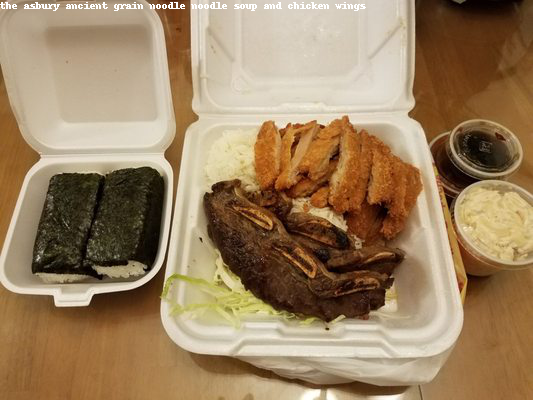

In [129]:
all_images[0]

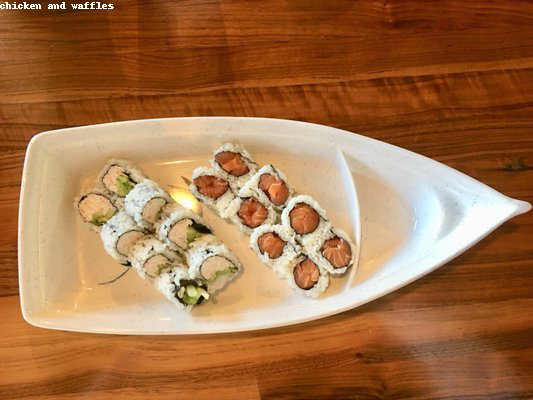

In [130]:
all_images[1]

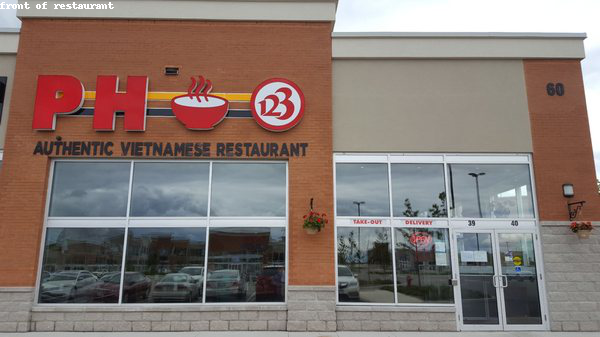

In [131]:
all_images[2]

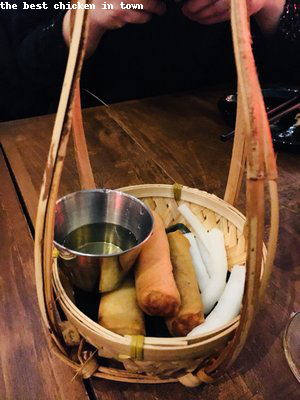

In [132]:
all_images[3]

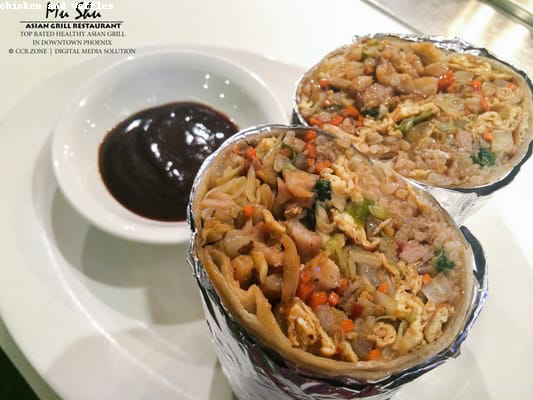

In [133]:
all_images[4]

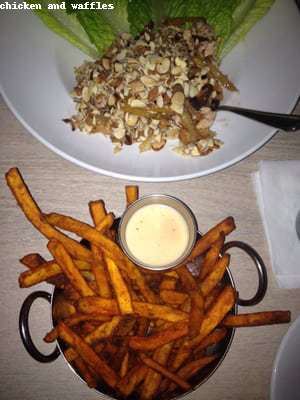

In [134]:
all_images[5]

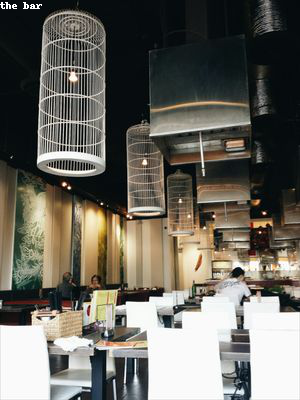

In [135]:
all_images[6]

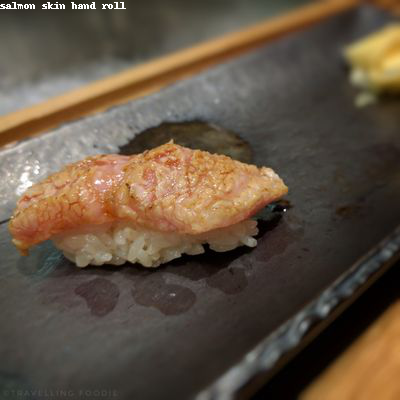

In [136]:
all_images[7]

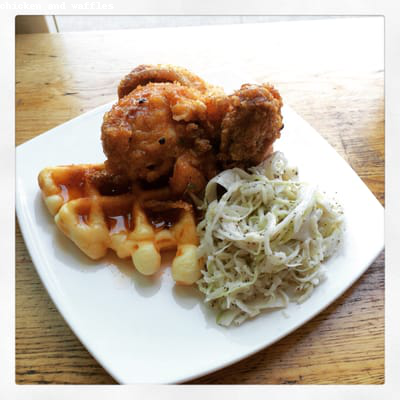

In [137]:
all_images[8]

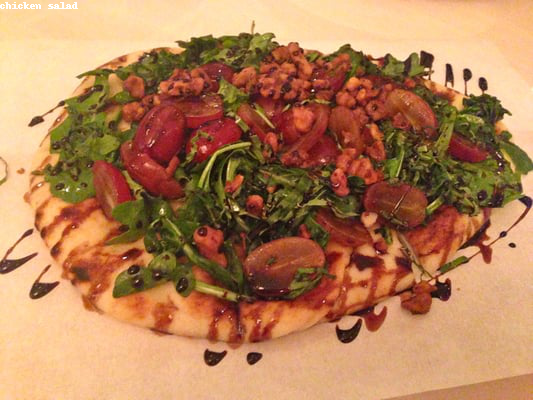

In [138]:
all_images[9]

In [169]:
for im in all_images[50:]:
    im.show()

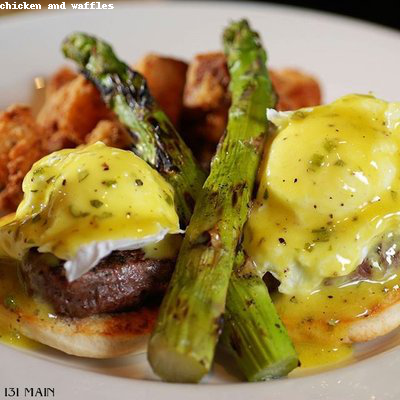

In [157]:
all_images[19]

In [163]:
choices[25]

'REmC_-oHdc8GJ5y9jmuQ8Q'

In [208]:
json = pd.read_json("../data/yelp_photos/photos.json", lines = True)

In [209]:
json = json.loc[json.caption != ""]

In [210]:
json.head()

,business_id,caption,label,photo_id
3,OnAzbTDn79W6CFZIriqLrA,Bakery area,inside,lHhMNhCA7rAZmi-MMfF3ZA
11,QqpzPFFHeHqyWSPZI-DkvQ,"The Hangar's house band, Tuned Up. Check our C...",inside,kHrkA-8BY4tC-rejiJNhBQ
12,77N3luh2YzfJFJGFIfqqbw,That's The man's butt. Ask him about beer (ale...,inside,ljStFDx0XFg8jSbJIRhvGA
15,3nR6JE3hD-D-Fhzr10_k7g,BBQ Shrimp,food,JoB_QTE2Hjr1NT0AgYdWzQ
16,3nR6JE3hD-D-Fhzr10_k7g,Sharkfin Pie,food,PvdNq213kqk7N9raOcefEw


In [211]:
json['has_chicken'] = json.caption.apply(lambda x : "chicken" in x)

In [212]:
json['has_waffles'] = json.caption.apply(lambda x : "waffles" in x)

In [213]:
json.head()

,business_id,caption,label,photo_id,has_chicken,has_waffles
3,OnAzbTDn79W6CFZIriqLrA,Bakery area,inside,lHhMNhCA7rAZmi-MMfF3ZA,False,False
11,QqpzPFFHeHqyWSPZI-DkvQ,"The Hangar's house band, Tuned Up. Check our C...",inside,kHrkA-8BY4tC-rejiJNhBQ,False,False
12,77N3luh2YzfJFJGFIfqqbw,That's The man's butt. Ask him about beer (ale...,inside,ljStFDx0XFg8jSbJIRhvGA,False,False
15,3nR6JE3hD-D-Fhzr10_k7g,BBQ Shrimp,food,JoB_QTE2Hjr1NT0AgYdWzQ,False,False
16,3nR6JE3hD-D-Fhzr10_k7g,Sharkfin Pie,food,PvdNq213kqk7N9raOcefEw,False,False


In [214]:
np.mean(json.has_chicken)

0.02105012548731735

In [215]:
np.mean(json.has_waffles)

0.0014979118513595287

In [217]:
json["has_seafood"] = json.caption.apply(lambda x: "seafood" in x)

In [218]:
np.mean(json.has_seafood)

0.001855029908637297